In [120]:
from tensorflow import keras
import tensorflow as tf

class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

def ctc_decode(y_pred):
    batch_size = tf.shape(y_pred)[0]
    input_length = tf.fill([batch_size], tf.shape(y_pred)[1])
    result = tf.keras.backend.ctc_decode(y_pred, input_length, greedy=True)[0][0][:, :max_len]
    return result
    
class CustomAccuracyMetric(keras.metrics.Metric):
    def __init__(self, name="custom_accuracy", **kwargs):
        super(CustomAccuracyMetric, self).__init__(name=name, **kwargs)
        self.correct_count = self.add_weight(name="correct_count", initializer="zeros")
        self.total_count = self.add_weight(name="total_count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_decoded = ctc_decode(y_pred)
        y_pred_decoded = tf.cast(y_pred_decoded, dtype=tf.float32)
        y_true = tf.cast(y_true, dtype=tf.float32)
        
        # Reshape y_true and y_pred to ensure they have the same shape
        y_true = tf.reshape(y_true, shape=(-1,))
        y_pred_decoded = tf.reshape(y_pred_decoded, shape=(-1,))
        
        values = tf.cast(tf.equal(y_true, y_pred_decoded), dtype=tf.float32)
        self.correct_count.assign_add(tf.reduce_sum(values))
        self.total_count.assign_add(tf.size(y_true))

    def result(self):
        return self.correct_count / self.total_count

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.correct_count.assign(0.)
        self.total_count.assign(0.)

In [121]:
from tensorflow.keras.models import load_model

custom_objects = {'CTCLayer': CTCLayer} #, 'CustomAccuracyMetric': CustomAccuracyMetric}

model = load_model('crnn_model_dt1.h5', custom_objects=custom_objects)

In [122]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

In [123]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

AUTOTUNE = tf.data.AUTOTUNE

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [124]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

#img = load_img('iam-handwriting-word-database/iam_words/words/a01/a01-000u/a01-000u-00-01.png', target_size=(image_height, image_width))
#img = load_img('iam-handwriting-word-database/iam_words/words/a01/a01-000u/a01-000u-00-01.png', color_mode='grayscale', target_size=(128, 32))

img_path = 'iam-handwriting-word-database/iam_words/words/a01/a01-000u/a01-000u-00-01.png'
img_path2 = 'iam-handwriting-word-database/iam_words/words/a01/a01-000u/a01-000u-05-05.png'
label = 'MOVE'
label2 = 'backed'

img_path3 = 'handwriting-recognition/test_v2/test/TEST_0048.jpg'
label3 = 'NARDINI'

#img_array = img_to_array(img)
#img_array = np.expand_dims(img_array, axis=0)

test_ds = prepare_dataset([img_path3], [label3])

#img = preprocess_image('iam-handwriting-word-database/iam_words/words/a01/a01-000u/a01-000u-00-01.png')
#pred = prediction_model.predict(img) #img_array)

In [125]:
max_len = 19

from tensorflow.keras.layers import StringLookup
vocab = ["'", '-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '`', 'a', 'b', 'c', 'e', 'i', 'l', 'm', 'o', 'r', 'u', 'y', 'z']
char_to_num = StringLookup(vocabulary=vocab, mask_token=None)
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

def calculate_match_percentage(actual, predicted):
    if len(actual) == 0:
        return 0.0
    match = sum([1 for a, b in zip(actual, predicted) if a == b])
    return match / len(actual)

def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [126]:
#pred_text = decode_batch_predictions(pred)

1/1 [==============================] - 1s 1s/step


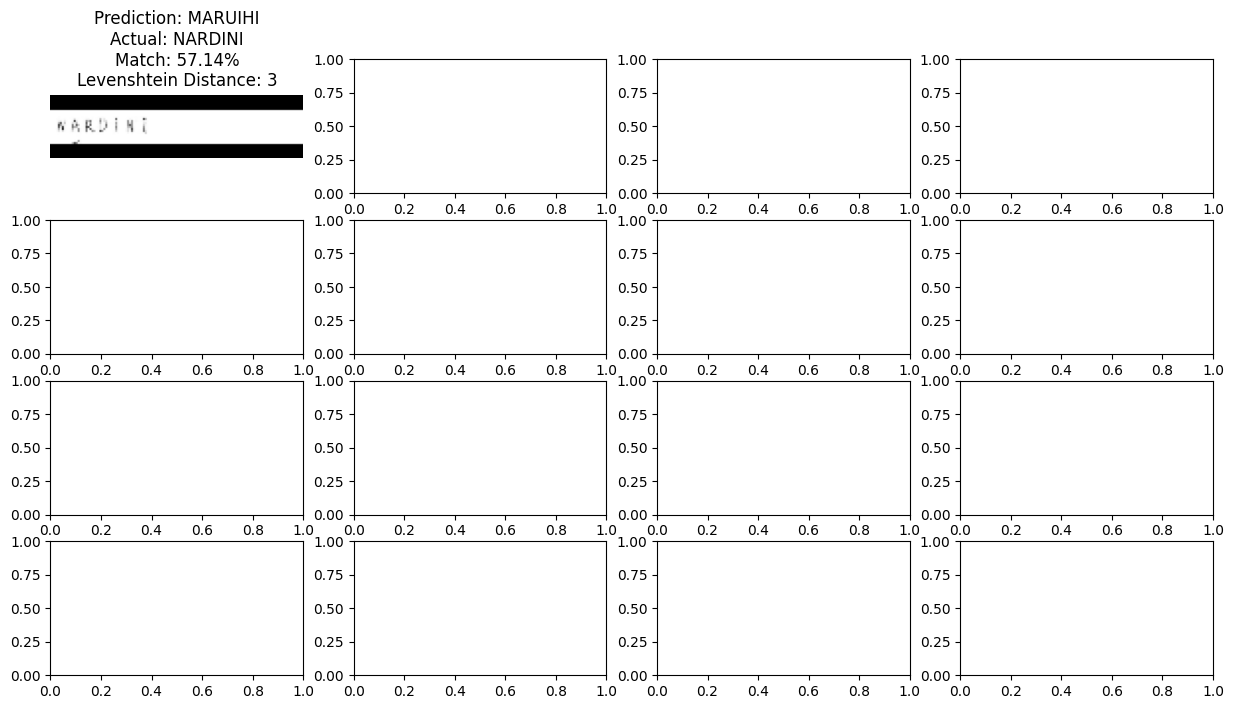

In [127]:
for batch in test_ds.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    
    for i in range(1):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token
        batch_label = batch_labels[i]
        indices = tf.gather(batch_label, tf.where(tf.math.not_equal(batch_label, padding_token)))
        # Convert to string.
        batch_label = tf.strings.reduce_join(num_to_char(indices))
        batch_label = batch_label.numpy().decode("utf-8")
        
        title = f"Prediction: {pred_texts[i]}\nActual: {batch_label}\nMatch: {calculate_match_percentage(batch_label, pred_texts[i]) * 100:.2f}%\nLevenshtein Distance: {levenshtein_distance(batch_label, pred_texts[i])}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()